# Convolutional Neural Network (CNN) to solve audio tagging problems

## Importing the necessary libararies for data creation,  visualization and plotting

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math

import librosa
import librosa.display

from scipy.stats import skew, kurtosis

import lightgbm as lgb

from sklearn.model_selection import train_test_split

import IPython
import IPython.display as ipd
import wave


### Loading files and performing exploratory analysis 

In [2]:
train_df_curated = pd.read_csv('train_curated.csv')
train_df_noisy = pd.read_csv('train_noisy.csv')
test_df = pd.read_csv('sample_submission.csv')

print('Train Curated\n',train_df_curated.head())
print("\nTrain Noisy\n",train_df_noisy.head(10))
print('\nTest\n',test_df.sample(5))

Train Curated
           fname           labels
0  0006ae4e.wav             Bark
1  0019ef41.wav         Raindrop
2  001ec0ad.wav  Finger_snapping
3  0026c7cb.wav              Run
4  0026f116.wav  Finger_snapping

Train Noisy
           fname                                          labels
0  00097e21.wav                    Bathtub_(filling_or_washing)
1  000b6cfb.wav                                      Motorcycle
2  00116cd2.wav              Marimba_and_xylophone,Glockenspiel
3  00127d14.wav  Water_tap_and_faucet,Sink_(filling_or_washing)
4  0019adae.wav                                        Raindrop
5  001b819d.wav                                     Bass_guitar
6  001c054e.wav                    Raindrop,Trickle_and_dribble
7  001ceaf1.wav                           Strum,Acoustic_guitar
8  001f3501.wav                                Bass_drum,Hi-hat
9  0020becb.wav                                       Harmonica

Test
              fname  Accelerating_and_revving_and_vroom  Accord

In [3]:
print("Unique Labels Curated: ",train_df_curated.labels.nunique(), "\nShape of the dataset: ",train_df_curated.shape,'\n')
print("Unique Labels Noisy: ",train_df_noisy.labels.nunique(), "\nShape of the dataset: ",train_df_noisy.shape, '\n')
print("Unique Labels Test: ",len(test_df.columns)-1, "\nShape of the dataset: ",test_df.shape)

Unique Labels Curated:  213 
Shape of the dataset:  (4970, 2) 

Unique Labels Noisy:  1168 
Shape of the dataset:  (19815, 2) 

Unique Labels Test:  80 
Shape of the dataset:  (3361, 81)


#### As we can see the noisy data is a lot more than the curated data, so we need to find a way to somehow use that noisy set.

- Since convolutional neural networks can discriminate spectro-temporal patterns (using log-scaled melspectograms to analyse audio content) and they can make distinctions when sound is masked by noise, adding noisy samples to the training data will be beneficial.

Total number of Single labels (Noisy) =  80


Text(0, 0.5, 'Labels')

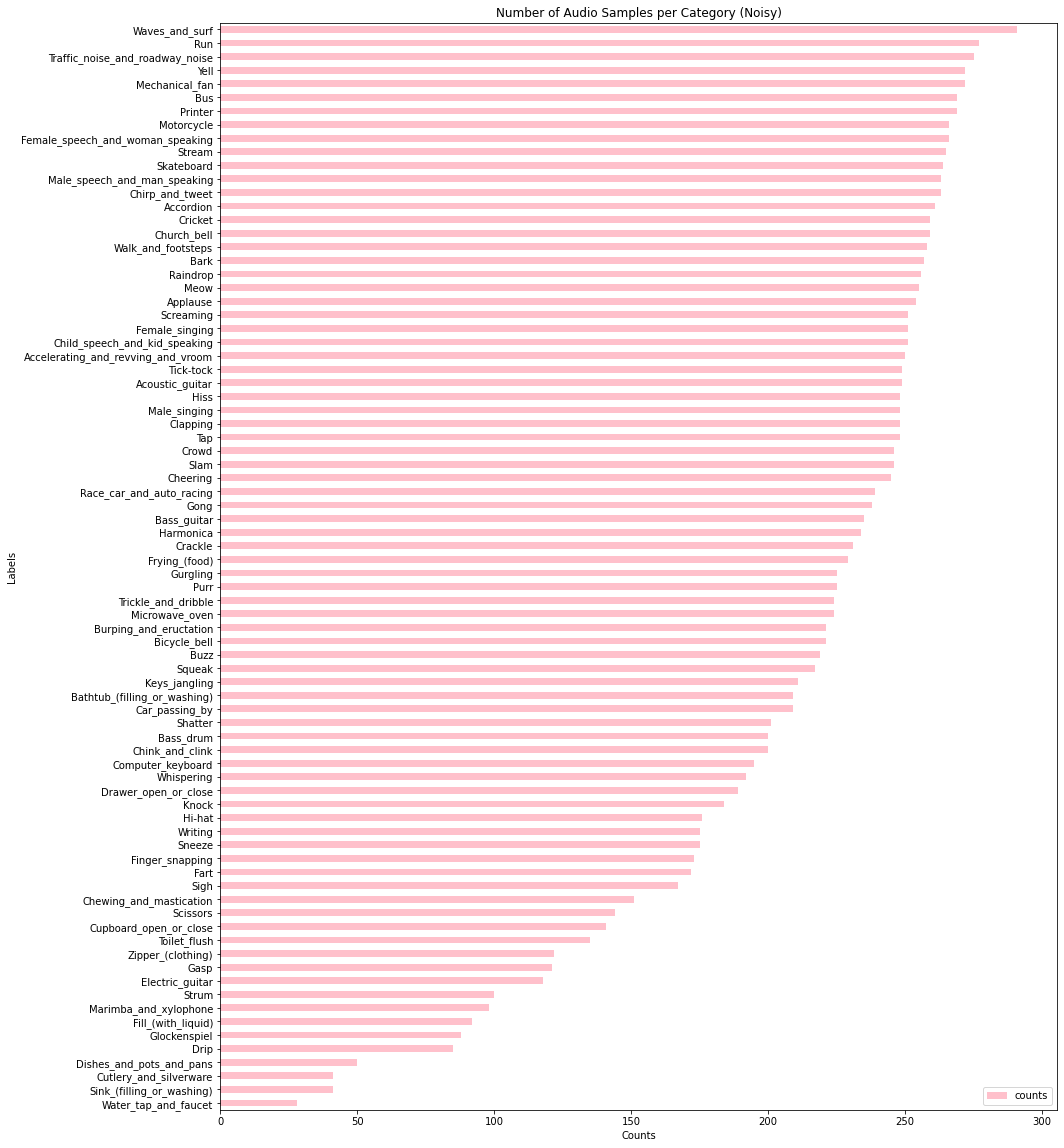

In [4]:
train_noisy_single_label = train_df_noisy[train_df_noisy.labels.isin(test_df.columns[1:])]

labels_noisy = train_noisy_single_label.groupby(['labels']).count()

print("Total number of Single labels (Noisy) = ", len(labels_noisy))

labels_noisy.columns= ['counts']

plot = labels_noisy.sort_values(ascending=True, by='counts').plot(kind='barh', 
    title="Number of Audio Samples per Category (Noisy)", color='pink', 
    figsize=(15,20))
plot.set_xlabel("Counts")
plot.set_ylabel("Labels")

Total number of Single labels (Curated) =  74


Text(0, 0.5, 'Labels')

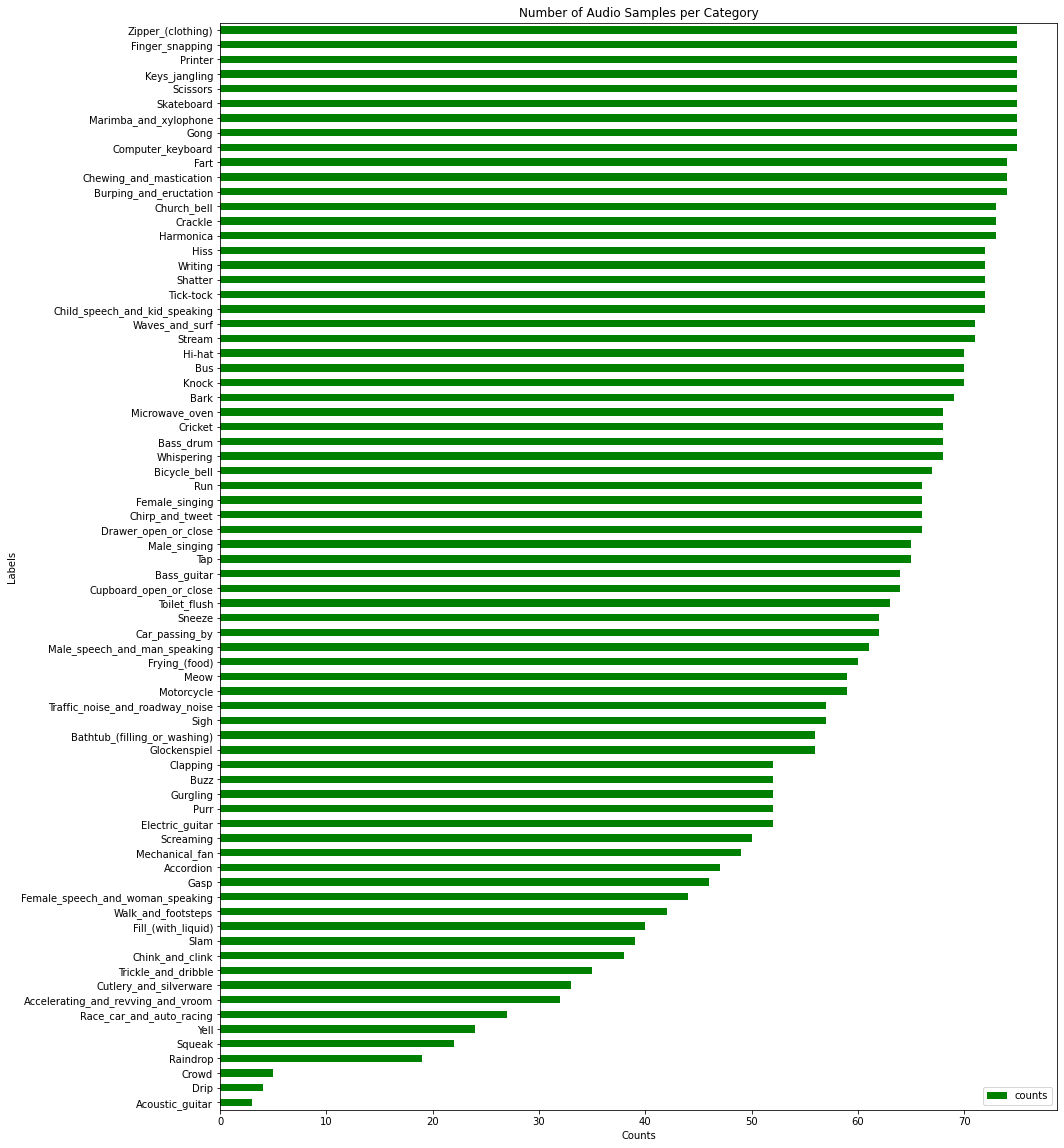

In [5]:
train_curated_single_label = train_df_curated[train_df_curated.labels.isin(test_df.columns[1:])]

labels_curated = train_curated_single_label.groupby(['labels']).count()

labels_curated.columns= ['counts']

print("Total number of Single labels (Curated) = ", len(labels_curated))

plot = labels_curated.sort_values(ascending=True, by='counts').plot(kind='barh', 
    title="Number of Audio Samples per Category", color='green', 
    figsize=(15,20))
plot.set_xlabel("Counts")
plot.set_ylabel("Labels")

#### As we  can see the number of single labels in curated  and noisy sets is 74 (<80 in test set) and 80 respectively.
#### So using both of the datasets, we will be able to build a model, which is more generalizable and we will have a lot more data to work with.
- We can check the matching labels of curated and test set, as well as noisy and test set
- Moreover, since the audio files, which have short durations (less than three seconds), don't contain much information in them, I have sorted use audio files that have at least 3 seconds duration.

In [6]:
train_df_curated['duration'] = train_df_curated['fname'].apply(
    lambda f: (wave.open('../Freesound Audio Tagging/train_curated_audio/' + f).getnframes())/(wave.open('../Freesound Audio Tagging/train_curated_audio/' + f).getframerate()))

train_df_noisy['duration'] = train_df_noisy['fname'].apply(
    lambda f: (wave.open('../Freesound Audio Tagging/train_noisy_audio/' + f).getnframes())/(wave.open('../Freesound Audio Tagging/train_noisy_audio/' + f).getframerate()))

train_df_curated = train_df_curated[(train_df_curated.labels.isin(test_df.columns[1:])) & (train_df_curated['duration'] >= 3)]
train_df_noisy = train_df_noisy[(train_df_noisy.labels.isin(test_df.columns[1:])) & (train_df_noisy['duration'] >= 3)]



print("Number of sorted items in Curated set: ", train_df_curated.shape[0],
     "\nNumber of sorted items in Noisy set: ", train_df_noisy.shape[0],
     "\nTotal sorted items =", train_df_curated.shape[0]+ train_df_noisy.shape[0])


Number of sorted items in Curated set:  2504 
Number of sorted items in Noisy set:  16545 
Total sorted items = 19049


In [7]:
noisy_labels = list(train_df_noisy.labels.unique())
label_index = {label: i for i, label in enumerate(noisy_labels)}
train_df_noisy["Label_Index"] = train_df_noisy.labels.apply(lambda x: label_index[x])
train_df_curated["Label_Index"] = train_df_curated.labels.apply(lambda x: label_index[x])


### Getting sound and log-scaled melspectogram of audio files

In [8]:
def get_audio_content(file_name):
    print(file_name)
    
    path = f'../Freesound Audio Tagging/train_curated_audio/{file_name}'
    IPython.display.display(ipd.Audio(path))
    
    wav = wave.open(path)
    print("Sampling (frame) rate = ", wav.getframerate())
    print("Total samples (frames) = ", wav.getnframes())
    print("Duration = ", wav.getnframes()/wav.getframerate())
    
    x, sr = librosa.load(path)
    
    ps = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(ps, y_axis='mel', x_axis='time')

Harmonica
ab87f49c.wav


Sampling (frame) rate =  44100
Total samples (frames) =  139095
Duration =  3.154081632653061


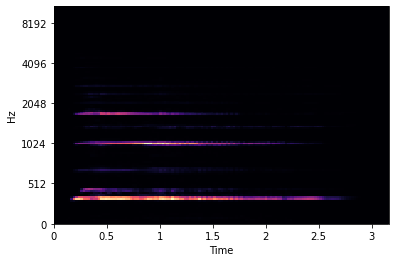

In [10]:
random_int = random.randint(0,4970)
random_wavefile = train_df_curated.fname.iloc[random_int]
print(train_df_curated.labels.iloc[random_int])

get_audio_content(random_wavefile)

In [11]:
x, sr = librosa.load('../Freesound Audio Tagging/train_curated_audio/d7f11d34.wav')
ps = librosa.feature.melspectrogram(y=x, sr=sr)
ps.shape

(128, 417)

#### As we can see the shape of the melspectogram vary depending on the duration of the audio.
#### Because of the fact that almost all of the sounds are monotonic, we can fix the duration of the audio to about 3 seconds (2.97 to be precise) in order to keep the shape of the melspectogram (128,128) intact and not lose a lot of valuable information.

### Splitting data to train, validation and test sets

In [8]:
import keras

from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential

In [14]:
Data = []

for row in train_df_curated.itertuples():
    path = '../Freesound Audio Tagging/train_curated_audio/' + row.fname
    x, sr = librosa.load(path, duration = 2.97)
    ps = librosa.feature.melspectrogram(y=x, sr=sr)
    if ps.shape != (128, 128):
        continue
    Data.append( (ps, row.Label_Index) )
    
    
for rows in train_df_noisy.itertuples():
    path = '../Freesound Audio Tagging/train_noisy_audio/' + rows.fname
    x, sr = librosa.load(path, duration = 2.97)
    ps = librosa.feature.melspectrogram(y=x, sr=sr)
    if ps.shape != (128, 128):
        continue
    Data.append( (ps, rows.Label_Index) )

In [15]:
len(Data)

19049

#### The split is done in 10/90 ratio. In this case it is approximately 3810 Testing and 15,239 Training

In [21]:
19049*0.1

1904.9

In [22]:
random.shuffle(Data)

test = np.asarray(Data[:2001])
train = np.asarray(Data[2001:])


X_train, Y_train = zip(*train)
X_test, Y_test = zip(*test)

Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)


X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])


Y_train = np.array(keras.utils.to_categorical(Y_train, 80))
Y_test = np.array(keras.utils.to_categorical(Y_test, 80))

### Modeling CNN

In [23]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(240))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(80))
model.add(Activation('softmax'))

In [24]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(x=X_train, y=Y_train, epochs=12, batch_size=128, validation_data= (X_test, Y_test))

score = model.evaluate(x=X_test, y=Y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
134/134 [==============================] - 90s 672ms/step - loss: 4.7869 - accuracy: 0.0160 - val_loss: 4.3477 - val_accuracy: 0.0240
Epoch 2/12
134/134 [==============================] - 92s 685ms/step - loss: 4.3031 - accuracy: 0.0252 - val_loss: 4.2210 - val_accuracy: 0.0340
Epoch 3/12
134/134 [==============================] - 93s 696ms/step - loss: 4.2029 - accuracy: 0.0321 - val_loss: 4.1429 - val_accuracy: 0.0395
Epoch 4/12
134/134 [==============================] - 101s 755ms/step - loss: 4.1356 - accuracy: 0.0399 - val_loss: 4.0565 - val_accuracy: 0.0555
Epoch 5/12
134/134 [==============================] - 96s 720ms/step - loss: 4.0577 - accuracy: 0.0500 - val_loss: 3.9509 - val_accuracy: 0.0690
Epoch 6/12
134/134 [==============================] - 91s 676ms/step - loss: 3.9679 - accuracy: 0.0611 - val_loss: 3.8620 - val_accuracy: 0.0735
Epoch 7/12
134/134 [==============================] - 91s 676ms/step - loss: 3.8917 - accuracy: 0.0724 - val_loss: 3.8014 - val_a

#### So, the accuracy score is 13.5%, which is bad.
#### Although CNN works relatively well with noisy audio data, one of the causes may be too much noisy data involved in training and the model could not make good predictions.

### We can try to train the model with all of curated data, little portion of noisy data and augment that data.

In [13]:
sample_noisy = train_df_noisy.sample(500)

In [21]:
Data_new = []

rates = [0.25,0.8]

for rate in rates:                                 # Change the duration of the audio
    for row in train_df_curated.itertuples():
        path = '../Freesound Audio Tagging/train_curated_audio/' + row.fname
        x, sr = librosa.load(path, duration = 2.97)
        x_changed = librosa.effects.time_stretch(x, rate=rate)
        ps = librosa.feature.melspectrogram(y=x_changed, sr=sr)
        if ps.shape != (128, 128):
            continue
        Data_new.append( (ps, row.Label_Index) )
        
pitches = [1.5,2.5]

for pitch in pitches:                               # Change the pitch of the audio
    for i in train_df_curated.itertuples():
        path = '../Freesound Audio Tagging/train_curated_audio/' + i.fname
        x, sr = librosa.load(path, duration = 2.97)
        x_changed = librosa.effects.pitch_shift(x, sr, n_steps=pitch)
        ps = librosa.feature.melspectrogram(y=x_changed, sr=sr)
        if ps.shape != (128, 128):
            continue
        Data_new.append( (ps, i.Label_Index) )
         

for j in train_df_curated.itertuples():
    path = '../Freesound Audio Tagging/train_curated_audio/' + j.fname
    x, sr = librosa.load(path, duration = 2.97)
    ps = librosa.feature.melspectrogram(y=x, sr=sr)
    if ps.shape != (128, 128):
        continue
    Data_new.append( (ps, j.Label_Index) )                        # Also adding oiginal data curated and 500 samples of noisy
    
    
for k in sample_noisy.itertuples():
    path = '../Freesound Audio Tagging/train_noisy_audio/' + k.fname
    x, sr = librosa.load(path, duration = 2.97)
    ps = librosa.feature.melspectrogram(y=x, sr=sr)
    if ps.shape != (128, 128):
        continue
    Data_new.append( (ps, k.Label_Index) )


So the above changes of the duration and the pitch of the audio data distort the original data. Meaning that we are adding new data to the original data without changing the labels.

#### After this repeating the process

In [22]:
print(len(Data_new))

random.shuffle(Data_new)

8012


In [23]:
test = np.asarray(Data_new[:751])
train = np.asarray(Data_new[751:])


x_train, y_train = zip(*train)
x_test, y_test = zip(*test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)


x_train = np.array([x.reshape( (128, 128, 1) ) for x in x_train])
x_test = np.array([x.reshape( (128, 128, 1) ) for x in x_test])


y_train = np.array(keras.utils.to_categorical(y_train, 80))
y_test = np.array(keras.utils.to_categorical(y_test, 80))

In [24]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(240))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(80))
model.add(Activation('softmax'))

In [26]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(x=x_train, y=y_train, epochs=12, batch_size=128, validation_data= (x_test, y_test))

score = model.evaluate(x=x_test, y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
57/57 [==============================] - 39s 684ms/step - loss: 4.9033 - accuracy: 0.0355 - val_loss: 4.2470 - val_accuracy: 0.0692
Epoch 2/12
57/57 [==============================] - 39s 685ms/step - loss: 4.2229 - accuracy: 0.0638 - val_loss: 4.0612 - val_accuracy: 0.1092
Epoch 3/12
57/57 [==============================] - 37s 644ms/step - loss: 4.0837 - accuracy: 0.0770 - val_loss: 3.8685 - val_accuracy: 0.1105
Epoch 4/12
57/57 [==============================] - 40s 704ms/step - loss: 3.9565 - accuracy: 0.0850 - val_loss: 3.7789 - val_accuracy: 0.1425
Epoch 5/12
57/57 [==============================] - 37s 654ms/step - loss: 3.8311 - accuracy: 0.1157 - val_loss: 3.6546 - val_accuracy: 0.1425
Epoch 6/12
57/57 [==============================] - 40s 709ms/step - loss: 3.7678 - accuracy: 0.1266 - val_loss: 3.5884 - val_accuracy: 0.1451
Epoch 7/12
57/57 [==============================] - 37s 641ms/step - loss: 3.6508 - accuracy: 0.1450 - val_loss: 3.5184 - val_accuracy: 0.1771

#### So, we can see that with proportionally more curated and augmented audio data, the model performed better. 25%

### Additional ideas that I have, but not eligible to implement at the moment
 
- Using some feature extraction techniques to separate noise from the labels. If somehow we can get more meaningful info out of noisy data set, that would be a big plus, because noisy data set has a lot more data than curated one.

- Trim the audio files and get rid of the silances, which don't add any useful information to the audio graphs. Aditionally, it would be nice to separate and relabel after trimming if the audio file has distinct sounds.

- Use some other model (e.x. Generative Advarsarial Networks) to artificially generate more diverse data for the model to train on.

